### 오차 확률: 앙상블의 예측이 틀릴 확률

이항 분포(binomial distribution)의 확률 질량 함수(probability mass function)으로 오차확률 표현 가능

$$ P(y \geq k) = \sum_{k}^{n} \varepsilon^{k}\begin{pmatrix}
n\\
k
\end{pmatrix}(1-\varepsilon)^{n-k} = \varepsilon_{ensemble}$$

$\varepsilon$: 에러율(error rate)

<b>확률 질량 함수</b>

In [12]:
from scipy.special import comb#이항계수(조합)
import math
def ensemble_error(n_classifier, error):#앙상블 오차 확률
    k_start = int(math.ceil(n_classifier/2.))#k
    probs = [comb(n_classifier, k)*#nCk
            error**k *#e^k
            (1-error)**(n_classifier-k) for k in range(k_start,n_classifier+1)]
    return sum(probs)

In [13]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

<b>앙상블과 개별 분류기 에러 사이의 관계</b>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier=11,error = error) for error in error_range]

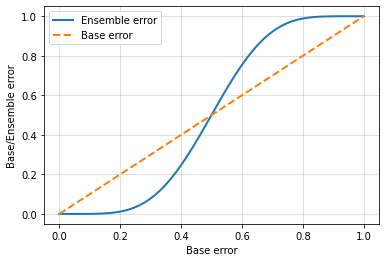

In [15]:
plt.plot(error_range, ens_errors, label = 'Ensemble error', linewidth = 2)#앙상블 에러
plt.plot(error_range, error_range, linestyle = '--', label = 'Base error', linewidth=2)#개별 분류기 에러
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha = 0.5)
plt.show()

#### 앙상블의 작동 방식

In [16]:
#클래스 소속 확률
ex =  np.array([[0.9,0.1],
                [0.8,0.2],
               [0.4,0.6]])

In [17]:
p = np.average(ex, axis=0, weights = [0.2,0.2,0.6])#가중치(weights)

In [18]:
p

array([0.58, 0.42])

In [19]:
np.argmax(p)

0

In [20]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [53]:
class MajorityVoteClassfier(BaseEstimator, ClassifierMixin):#다수결 투표 앙상블 분류기
    def __init__(self, classifiers, vote = 'classlabel',weights = None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for
                                 key, value in
                                 _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights#가중치
    
    #self.predict 매서드에서 np.argmax를 호출할 때
    #클래스 레이블이 0부터 시작되어야 함
    def fit(self,X,y):#분류기를 학습
        self.lablenc_ = LabelEncoder()#클래스 레이블 0부터 시작
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifers_.append(fitted_clf)
        
        return self
    
    
    
    def predict(self,X):#예측
        if self.vote == 'probability':#클래스 소속 확률을 기반으로 클래스 레이블 예측
            maj_vote = np.argmax(self.predict_proba(X),axis = 1)#예측된 클래스 레이블
        else:#classlabel투표
            #clf.predict 매서드를 사용하여 결과를 모음
            predictions = np.asarray([clf.predict(X) for clf in self.classifers_]).T#결과를 모음
            
            maj_vote = np.apply_along_axis(
                lambda x : 
                np.argmax(np.bincount(x,
                                      weights = self.weights)), 
                axis = 1, 
                arr = predictions)#확룰 힙이 가장 큰 인덱스
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    
    
    def predict_proba(self, X):#클래스 확률 예측
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifers_])
        avg_proba = np.average(probas,
                               axis = 0, weights = self.weights)
        return avg_proba
    
    def get_params(self, deep = True):#분류기의 매개변수 이름 반환
        """GridSEarch를 위해 분류기의 매개변수 이름을 반환"""
        if not deep:
            return super(MajorityVoteClassfier, 
                         self).get_params(deep =False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                    step.get_params(deep=True)):
                    out['%s__%s'%(name, key)] = value
            return out

### 다수결 투표 방식을 사용하여 예측 만들기

In [24]:
from sklearn import datasets

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [27]:
iris = datasets.load_iris()#붓꽃 데이터셋

In [28]:
X,y = iris.data[50:,[1,2]],iris.target[50:]#꽃받침 너비와 꽃잎 길이 두 개 특성

In [29]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5, random_state=1, stratify=y)

세 분류기: <br>
- 로지스틱 회귀 분류기<br>
- 결정 트리 분류기<br>
- k-최근접 이웃 분류기

In [54]:
#각자 예측했을 때
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

#분류기 1
clf1 = LogisticRegression(solver='liblinear',#로지스틱 회귀 분류기
                         penalty='l2',#L2규제
                         C=0.001,
                         random_state=1)
#분류기 2
clf2 = DecisionTreeClassifier(max_depth=1,#결정 트리 분류기
                             criterion = 'entropy',#불순도 지표: 엔트로피,
                             random_state=0)

#분류기 3
clf3 = KNeighborsClassifier(n_neighbors=1,#K-최근접 이웃 분류기
                           p = 2,#유클리디안 거리
                           metric = 'minkowski')
pipe1 = Pipeline([['sc',StandardScaler()],#표준화 전처리
                 ['clf',clf1]])#로지스틱 회귀
pipe3 = Pipeline([['sc', StandardScaler()],#표준화 전처리
                 ['clf',clf3]])#K-최근접 이웃

clf_labels= ['Logistic regression','Decision Tree', 'KNN']#분류기 이름 저장
print("10-겹 교차 검증 :\n")
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator =clf,
                            X= X_train,
                            y = y_train,
                            cv = 10,#10겹 교차검증
                            scoring='roc_auc')#ROC AUC(분류모델 성능 조사)
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"%(scores.mean(), scores.std(),label))

10-겹 교차 검증 :

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [55]:
#앙상블로 예측했을 때
mv_clf = MajorityVoteClassfier(
    classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,
                            X= X_train,
                            y = y_train,
                            cv = 10,#10겹 교차 검증
                            scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"%(scores.mean(),scores.std(),label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority Voting]


### 앙상블 분류기의 평가와 튜닝

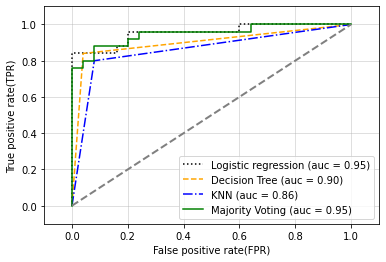

In [56]:
#앙상블 분류기의 일반화 성능 확인 위한 ROC 곡선 그리기
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black','orange','blue','green']
linestyles = [':','--','-.','-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    #양성 클래스의 레이블이 1이라고 가정
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,-1]#테스트세트
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)#일반화 성능 확인
    roc_auc = auc(x=fpr,y=tpr)#roc auc계산
    plt.plot(fpr,tpr,color=clr,linestyle=ls,label='%s (auc = %0.2f)'%(label,roc_auc))#roc auc 표기
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--', color='gray', linewidth =2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate(FPR)')
plt.ylabel('True positive rate(TPR)')
plt.show()

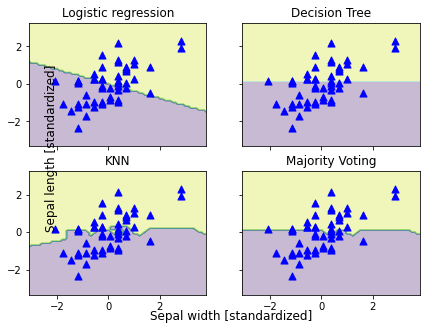

In [57]:
#앙상블의 결정 경계 그리기
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)#결정 트리 스케일 맞추기 위한 표준화 전처리
from itertools import product
x_min = X_train_std[:,0].min()-1
x_max = X_train_std[:,0].max()+1
y_min = X_train_std[:,1].min()-1
y_max = X_train_std[:,1].max()+1
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows= 2, ncols=2,
                       sharex = 'col',
                       sharey = 'row',
                       figsize = (7,5))
for idx,clf,tt in zip(product([0,1],[0,1]),
                     all_clf, clf_labels):#분류기마다 결정 경계 그리기
    clf.fit(X_train_std,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train == 0,0],#클래스 0
                                X_train_std[y_train == 0,1],
                                c='blue',
                                marker='^',
                                s=50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train == 1,0],#클래스 0
                                X_train_std[y_train == 1,1],
                                c='blue',
                                marker='^',
                                s=50)
    axarr[idx[0],idx[1]].set_title(tt)
plt.text(-3.5,-4.5,s="Sepal width [standardized]",ha='center',va='center',fontsize=12)

plt.text(-10.5,4.5,s="Sepal length [standardized]",ha='center',va='center',fontsize=12, rotation =90)
plt.show()

In [58]:
#매개변수
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf',
                  LogisticRegression(C=0.001, random_state=1,
                                     solver='liblinear')]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1, solver='liblinear')]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1, solver='liblinear'),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf_

#### 그리드서치를 통한 하이퍼파라미터 튜닝

튜닝 대상:
- 로지스틱 회귀 분류기의 규제 매개변수 C
- 결정 트리의 깊이

In [61]:
mv_clf.get_params().keys()

dict_keys(['pipeline-1', 'decisiontreeclassifier', 'pipeline-2', 'pipeline-1__memory', 'pipeline-1__steps', 'pipeline-1__verbose', 'pipeline-1__sc', 'pipeline-1__clf', 'pipeline-1__sc__copy', 'pipeline-1__sc__with_mean', 'pipeline-1__sc__with_std', 'pipeline-1__clf__C', 'pipeline-1__clf__class_weight', 'pipeline-1__clf__dual', 'pipeline-1__clf__fit_intercept', 'pipeline-1__clf__intercept_scaling', 'pipeline-1__clf__l1_ratio', 'pipeline-1__clf__max_iter', 'pipeline-1__clf__multi_class', 'pipeline-1__clf__n_jobs', 'pipeline-1__clf__penalty', 'pipeline-1__clf__random_state', 'pipeline-1__clf__solver', 'pipeline-1__clf__tol', 'pipeline-1__clf__verbose', 'pipeline-1__clf__warm_start', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_

In [63]:
from sklearn.model_selection import GridSearchCV#그리드서치
params = {'decisiontreeclassifier__max_depth':[1,2],#결정 트리 깊이
         'pipeline-1__clf__C':[0.001,0.1,100.0]}#로지스틱 회귀 분류기의 규제 매개변수 C
grid = GridSearchCV(estimator=mv_clf,
                   param_grid=params,
                   cv=10,#10겹 교차 검증
                   scoring = 'roc_auc'#ROC AUC 점수
                   )

grid.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassfier(classifiers=[Pipeline(steps=[('sc',
                                                                           StandardScaler()),
                                                                          ['clf',
                                                                           LogisticRegression(C=0.001,
                                                                                              random_state=1,
                                                                                              solver='liblinear')]]),
                                                          DecisionTreeClassifier(criterion='entropy',
                                                                                 max_depth=1,
                                                                                 random_state=0),
                                                          Pipeline(steps=[('sc',
                 

각각의 하이퍼파라미터 조합과 10-겹 교차검증으로 계산한 평균 ROC AUC 점수

In [65]:
for i in len(grid.cv_results_['mean_test_score']):
    print("%0.3f +/-%0.2f %r"
         %(grid.cv_results_['mean_test_score'][i], scores.std()/2, grid.cv_results_['mean_test_score']))

ValueError: too many values to unpack (expected 3)

In [73]:
for params, mean_score, scores in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score'],grid.cv_results_['std_test_score']):
    print("%0.3f +/- %0.2f %r"%(mean_score,scores,params))

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [76]:
print("최적의 매개변수: %s"%grid.best_params_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [77]:
print("정확도: %.2f"%grid.best_score_)

정확도: 0.98


## 배깅: 부트스트랩 샘플링을 통한 분류 앙상블
앙상블에 있는 개별 분류기를 동일한 훈련 세트로 학습하는 것이 아니라 원본 훈련 세트에서 <b>부트스트랩(bootstrap) 샘플(중복을 허용한 랜덤 샘플)</b>을 뽑아서 사용.
<br>


In [123]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/''machine-learning-databases/wine/wine.data',header=None)

In [124]:
df_wine.columns = ['Class label','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total pheols','Flabanoids',
                  'Nonflavanoid phenols','Proanthocyanins','Color intensity',
                  'Hue','OD280/OD315 of diluted wines','Proline']

In [125]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total pheols,Flabanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [126]:
#클래스 1 제외하기
df_wine = df_wine[df_wine['Class label']!=1]

In [127]:
y = df_wine['Class label'].values

In [130]:
X= df_wine[['Alcohol','OD280/OD315 of diluted wines']].values

In [131]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)#이진 형태로 인코딩
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [133]:
from sklearn.ensemble import BaggingClassifier#배깅
tree = DecisionTreeClassifier(criterion='entropy',random_state=1, max_depth=None)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, 
                        bootstrap_features=False,n_jobs=1,random_state=1)

In [136]:
from sklearn.metrics import accuracy_score#예측 정확도
tree = tree.fit(X_train,y_train)#가지치기가 없는 단일 결정 트리
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)

print("결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f"%(tree_train,tree_test))#배깅 없이는 과대적합이 나타남

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833


In [138]:
bag = bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print("배깅의 훈련 정확도/테스트 정확도: %.3f/%.3f"%(bag_train,bag_test))#배깅 분류기의 일반화 성능이 더 나음

배깅의 훈련 정확도/테스트 정확도: 1.000/0.917


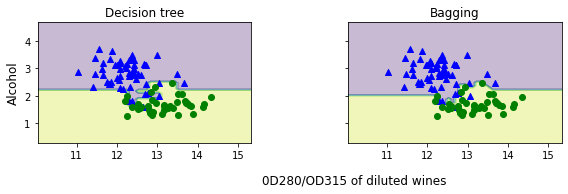

In [141]:
#결정 트리와 배깅 분류기의 결정 경계 비교
x_min = X_train[:,0].min()-1
x_max = X_train[:,0].max()+1
y_min = X_train[:,1].min()-1
y_max = X_train[:,1].max()+1

xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f,axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))

for idx, clf, tt in zip([0,1],[tree,bag],['Decision tree','Bagging']):
    clf.fit(X_train,y_train)
    
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0,0],
                      X_train[y_train==0,1],
                      c='blue',marker='^')
    axarr[idx].scatter(X_train[y_train == 1,0],
                      X_train[y_train==1,1],
                      c='green',marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol',fontsize=12)
plt.text(10.2,-1.2,s = '0D280/OD315 of diluted wines',ha = 'center', fontsize=12)
plt.tight_layout()
plt.show()#배깅 앙상블에서 선형 결정 경계가 더 부드러워짐

### 7.4 약한 학습기를 이용한 에이다부스트

부스팅의 핵심: 분류하기 어려운 훈련 샘플에 초점을 맞추는 것

#### 부스팅 작동 원리
1. 훈련 세트 D에서 중복을 허용하지 않고 랜덤한 부분 집합 $d_1$을 뽑아 약한 학습기 $C_1$을 훈련
2. 훈련 세트에서 중복을 허용하지 않고 두 번째 랜덤한 훈련 부분 집합 $d_2$를 뽑고 이전에 잘못 분류된 샘플의 50%를 더해서 약한 학습기 $C_2$를 훈련
3. 훈련 세트 D에서 $C_1$과 $C_2$에서 잘못 분류한 훈련 샘플 $d_3$를 찾아 세 번째 약한 학습기인 $C_3$를 훈련
4. 약한 학습기 $C_1$, $C_2$, $C_3$를 다수결 투표로 연결

에이다부스트는 과대적합되는 경향이 있음

#### 에이다부스트 의사코드
1. 가중치 벡터 w를 동일한 가중치로 설정한다. $\sum\nolimits_{i}w_i = 1$
<br><br>
2. m번 부스팅 반복의 j번째에서 다음을 수행<br>

    a. 가중치가 부여된 약한 학습기를 훈련 $C_j = train(X,y,w)$<br>
    b. 클래스 레이블을 예측 $\hat{y} = predict(C_j,X)$<br>
    c. 가중치가 적용된 에러율을 계산 $ \varepsilon = w\cdot (\hat{y}\neq y)$<br>
    d. 학습기 가중치를 계산 $\alpha_j = 0.5log\frac{1-\varepsilon}{\varepsilon}$<br>
    e. 가중치를 업데이트 $w := w$ x $exp(-\alpha_j$x$\hat{y}$x$y)$<br>
    f. 합이 1이 되도록 가중치 정규화 $w := w$ / $\sum\nolimits_{i}w_i$<br>
<br><br>
3. 최종 예측을 계산 $\hat{y} = (\sum\nolimits_{i=1}^{m}(\alpha_j$ x $predict(C_j,X))>0)$

<br><br>
$(\hat{y}\neq y)$ 표현은 1 또는 0으로 구성된 이진 벡터다. 예측이 잘못되면 1이고 정확하면 0이다.

### 사이킷런에서 에이다부스트 사용

In [142]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion = 'entropy',#결정트리
                             random_state=1,
                             max_depth=1)#깊이 1(약한 훈련기)
ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,#500개 트리
                        learning_rate=0.1,
                        random_state=1)

In [143]:
tree = tree.fit(X_train,y_train)

In [144]:
y_train_pred = tree.predict(X_train)

In [145]:
y_test_pred = tree.predict(X_test)

In [146]:
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print("결정 트리의 훈련 정확도/테스트 정확도: %.3f/%.3f"%(tree_train,tree_test))

결정 트리의 훈련 정확도/테스트 정확도: 0.916/0.875


In [147]:
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print("에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f"%(ada_train,ada_test))

에이다부스트의 훈련 정확도/테스트 정확도 1.000/0.917


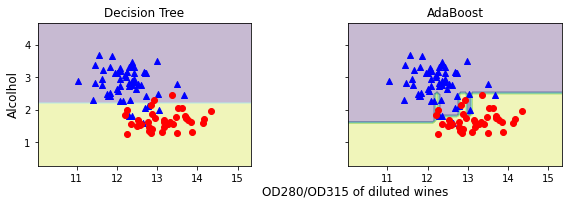

In [149]:
#에이다부스트의 결정 영역
x_min = X_train[:,0].min()-1
x_max = X_train[:,0].max()+1
y_min = X_train[:,1].min()-1
y_max = X_train[:,1].max()+1
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))

f, axarr = plt.subplots(1,2,
                       sharex='col',
                       sharey='row',
                       figsize = (8,3))

for idx, clf, tt in zip([0,1],
                       [tree,ada],
                       ['Decision Tree','AdaBoost']):
    clf.fit(X_train,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z= Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0,0],
                      X_train[y_train == 0,1],
                      c='blue',
                      marker = '^')
    axarr[idx].scatter(X_train[y_train==1,0],
                      X_train[y_train ==1,1],
                      c='red',
                      marker = 'o')
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel('Alcolhol',fontsize=12)
plt.text(10.2,-0.5, s = 'OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12)
plt.tight_layout()
plt.show()

### 그래디언트 부스팅(Gradient Boosting)

In [153]:
from sklearn.ensemble import GradientBoostingClassifier#그래디언트 부스팅 모델
gbrt = GradientBoostingClassifier(n_estimators=20, random_state = 42)#트리 개수 20개
gbrt.fit(X_train,y_train)
gbrt_train_score = gbrt.score(X_train,y_train)
gbrt_test_score = gbrt.score(X_test,y_test)
print("앙상블에 사용한 트리개수: %d"%gbrt.n_estimators_)

앙상블에 사용한 트리개수: 20


In [155]:
print("그래디언트 부스팅의 훈련 정확도/테스트 정확도 %.3f/%.3f"%(gbrt_train_score,gbrt_test_score))

그래디언트 부스팅의 훈련 정확도/테스트 정확도 1.000/0.917


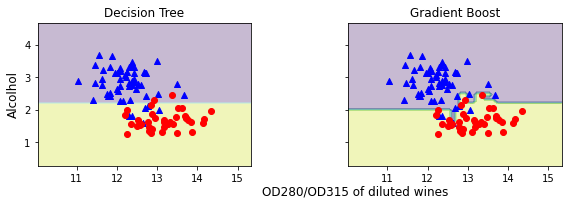

In [156]:
#에이다부스트의 결정 영역
x_min = X_train[:,0].min()-1
x_max = X_train[:,0].max()+1
y_min = X_train[:,1].min()-1
y_max = X_train[:,1].max()+1
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))

f, axarr = plt.subplots(1,2,
                       sharex='col',
                       sharey='row',
                       figsize = (8,3))

for idx, clf, tt in zip([0,1],
                       [tree,gbrt],
                       ['Decision Tree','Gradient Boost']):
    clf.fit(X_train,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z= Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0,0],
                      X_train[y_train == 0,1],
                      c='blue',
                      marker = '^')
    axarr[idx].scatter(X_train[y_train==1,0],
                      X_train[y_train ==1,1],
                      c='red',
                      marker = 'o')
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel('Alcolhol',fontsize=12)
plt.text(10.2,-0.5, s = 'OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12)
plt.tight_layout()
plt.show()

히스토그램 기반 부스팅 알고리즘

In [157]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [160]:
hgbrt = HistGradientBoostingClassifier( random_state = 42)#트리 개수 20개
hgbrt.fit(X_train,y_train)
hgbrt_train_score = hgbrt.score(X_train,y_train)
hgbrt_test_score = hgbrt.score(X_test,y_test)

In [161]:
print("히스토그램 기반 부스팅의 훈련 정확도/테스트 정확도 %.3f/%.3f"%(hgbrt_train_score,hgbrt_test_score))

히스토그램 기반 부스팅의 훈련 정확도/테스트 정확도 0.979/0.917


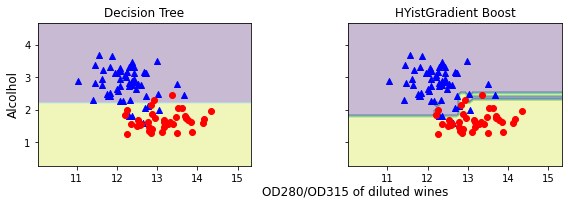

In [163]:
#에이다부스트의 결정 영역
x_min = X_train[:,0].min()-1
x_max = X_train[:,0].max()+1
y_min = X_train[:,1].min()-1
y_max = X_train[:,1].max()+1
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))

f, axarr = plt.subplots(1,2,
                       sharex='col',
                       sharey='row',
                       figsize = (8,3))

for idx, clf, tt in zip([0,1],
                       [tree,hgbrt],
                       ['Decision Tree','HYistGradient Boost']):
    clf.fit(X_train,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z= Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0,0],
                      X_train[y_train == 0,1],
                      c='blue',
                      marker = '^')
    axarr[idx].scatter(X_train[y_train==1,0],
                      X_train[y_train ==1,1],
                      c='red',
                      marker = 'o')
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel('Alcolhol',fontsize=12)
plt.text(10.2,-0.5, s = 'OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12)
plt.tight_layout()
plt.show()